#  <center> <u>Investment and Trading:</u> </center> <center>Stock Predictor</center>

# <u>Definition</u>

### Project Overview

The stock market is a collection of buyers and sellers of fractions of company ownership. Buyers and sellers can take a variety of forms from individuals to investment firms to funds. Their goal is to understand how to make more profitable decisions with their investments. Copious data is available in the form of historical prices. These prices will be used to generate training data for machine learning algorithms.

The endeavor of this project will be to provide return predictions for investments over a user defined period from the present day.

Data used in this project is retrieved from the Yahoo Finance API provided through the `pandas` library. Historical data including the information of concern, adjusted closing prices, are retrieved using a company symbol, an all uppercase group of characters representing how the company is referred to in the market ("AAPL" for Apple, "ABC" for Google, "IBM" for IBM). The historical adjusted closing prices are requested for all trading days in the past year up to the day the program is run as specified in the project `README.md` file.

### Problem Statement

Accurate predictions of future stock returns provide the opportunity to make profitable and responsible investments. Stock price movements, increases and decreases in stock value, are known to be difficult to predict. Stock prices are subject to a lot of context created by participants in the stock market. While saturated with noise, there is still information that can be exploited to make more responsible market strategies.

### Metrics

The metrics used to measure the performance of the models will be Root Mean Squared Error (RMSE), Mean Average Percentage Error (MAPE), and Correlation. 

RMSE makes sense to use in most contexts because it gives a scale of the regression error in the same units as the prediction itself. MAPE, on the other hand, makes sense to use when the outcome in question is the future stock price and not the return. MAPE gives an estimate of the error as a percentage of the overall price of a stock. Since the outcome this project will focus on is investment return (future price / present price - 1) which is normally on a scale from -1 to +1, this project will display RMSE for aesthetic purposes. In other words, RMSE displays a less intimidating view of the error.

Correlation is also displayed to show how well the predictions trend with the true value of the returns. The benchmark for this is set in the analysis section by analyzing how well the current price correlates with future results.

# <u>Analysis</u>

### Data Exploration

The complex nature of presenting this data is that trends in the stock market are constantly changing. In this project, a variety of Company symbols will be used to display how the analysis was conducted. The figure below is an example of how random the market returns seem.

In [1]:
# Import Python Libraries necessary for the report
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Import personal libraries developed for project available on github for exploration:
# https://github.com/Seananigans/Finance/tree/master/StockPredictor
from dataset_construction import create_input, create_output, get_and_store_web_data
from predict_future import predict_spy_future

In [2]:
# Create features dataset and output dataset
ibm = create_input("IBM")
ibm_future_prices = create_output("IBM", use_prices=True)
ibm_future_returns = create_output("IBM", use_prices=False)
ibm_future_prices.columns = ["Future_IBM"]
ibm_future_returns.columns = ["Returns_IBM"]

# Display the joined Dataset
ibm_price_returns_df = ibm.join(ibm_future_prices).join(ibm_future_returns)
num_days = ibm_price_returns_df.shape[0]
print ibm_price_returns_df.iloc[:6]
print

# Display Statistics about output variable
print "There are {} days/observations in the data.".format(ibm_price_returns_df.shape[0])
print "{} or {:.2f}% of those days observe a 5 day future return ABOVE zero.".format(
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM>0.0].shape[0],
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM>0.0].shape[0]/float(num_days)*100.)
print "{} or {:.2f}% of those days observe a 5 day future return EQUAL TO or BELOW zero.".format(
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM<=0.0].shape[0],
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM<=0.0].shape[0]/float(num_days)*100.)
print "{} of those days observe a 5 day future return that is not a number (eg. NaN).".format(
    ibm_price_returns_df[np.isnan(ibm_price_returns_df.Returns_IBM)].shape[0])
print "The average 5 day future return for all days in this dataset is {:.4f} with a standard deviation of {:.4f}.".format(
    ibm_price_returns_df.Returns_IBM.mean(), ibm_price_returns_df.Returns_IBM.std()
)

            AdjClose_IBM  Future_IBM  Returns_IBM
Date                                             
2013-06-14    185.494397  179.311259    -0.033333
2013-06-17    186.264993  177.549876    -0.046789
2013-06-18    187.943802  178.870906    -0.048275
2013-06-19    185.255883  178.760825    -0.035060
2013-06-20    181.045108  179.485550    -0.008614
2013-06-21    179.311259  175.320647    -0.022255

There are 755 days/observations in the data.
375 or 49.67% of those days observe a 5 day future return ABOVE zero.
375 or 49.67% of those days observe a 5 day future return EQUAL TO or BELOW zero.
5 of those days observe a 5 day future return that is not a number (eg. NaN).
The average 5 day future return for all days in this dataset is -0.0009 with a standard deviation of 0.0270.


### Exploratory Visualization

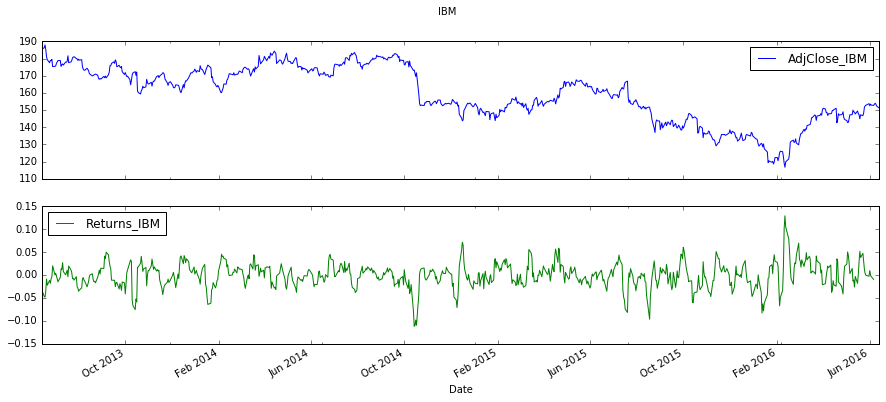

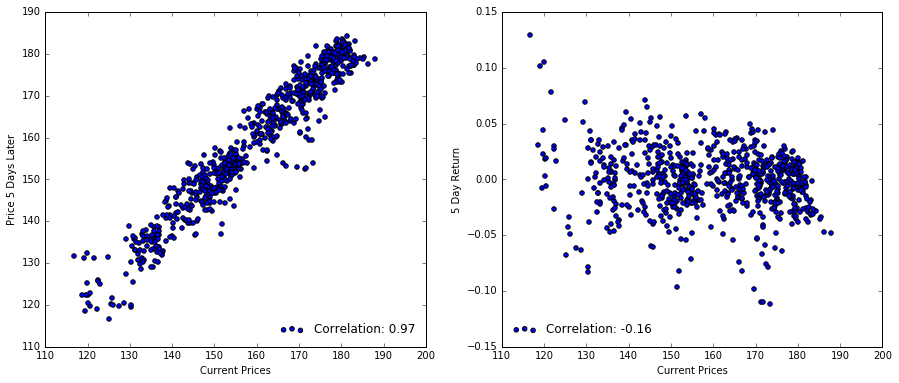

In [3]:
# Display Prices and returns over whole timeline for example dataset IBM
ibm.join(ibm_future_returns).plot(subplots=True,figsize=(15,6), title="IBM")

prices_corr = ibm.join(ibm_future_prices).corr()["AdjClose_IBM"]["Future_IBM"]
returns_corr = ibm.join(ibm_future_returns).corr()["AdjClose_IBM"]["Returns_IBM"]

# Display how current price relates to 5 day future returns and prices
f, axarr = plt.subplots(1,2, figsize=(15,6))
axarr[0].scatter(ibm, ibm_future_prices, label="Correlation: {}".format(round(prices_corr,2)))
axarr[0].set_xlabel('Current Prices')
axarr[0].set_ylabel('Price 5 Days Later')
axarr[0].legend(loc="lower right", frameon=False)
axarr[1].scatter(ibm, ibm_future_returns, label="Correlation: {}".format(round(returns_corr,2)))
axarr[1].set_xlabel('Current Prices')
axarr[1].set_ylabel('5 Day Return')
axarr[1].legend(loc="lower left", frameon=False)

plt.show()

When prices are low, prices 5 days later are likely to remain low by comparison. On the other hand, there is a moderate negative correlation between current price and 5 day returns. This implies that when prices are low, a positive return would be expected, while when prices are high, a negative return is somewhate more likely.

While model performance will be explored for predicting future price, the main concern of any investor is the future return. For that reason, the overall goal of the project is to out-perform the benchmark for predicting returns.

### Algorithms and Techniques

A variety of indicators are used to analyze the movement of prices in the market. This section will discuss some of the indicators used and how they were tested to determine which would be most effective. 

The list of indicators tested were:
* Window based Indicators:
    * N-Day Bollinger Value
        - _(Price[ t ] - N-day Moving Average) / ( 2 * N-day Standard Deviation of the Price )_
    * Exponential Moving Average (EMA)
        - _(Price[ t ] - EMA[ t-1 ]) * (2/(N+1)) + EMA[ t-1 ]_
    * N-day Simple Moving Average (SMA)
        - Average( _Price[ t-N ] to Price[ t ]_ )
    * N-day Momentum
        - _Price[ t ] / Price[ t-N ] - 1_
    * Relative Strength Index (RSI)
        - RSI = _100 - 100/(1+RS)_
        - RS = _N-day Average Gain / N-day Average Loss_
    * Volatility
        - N-day Standard Deviation of the Price 
* One non-window based indicator:
    * Weekdays
        - Is it Monday? [0 or 1]
        - Is it Tuesday? [0 or 1], 
        - etc.
        
Every window indicator was analyzed for varying window size from a one-day window to a thirty-day window. 

For every member of the S&P 500 list found in `spylist.csv`:

    1) A dataset was created with the specified indicator and specified window.
    2) The dataset was split into training and testing data.
    3) A linear regression model was trained using training data.
    4) The linear regression model predictions were compared the test data.
    5) Test error for the indicator was added to a running total over the S&P 500 list.
    6) Test errors were sorted to find the best performing indicator window.

The top three performing windows for each indicator were added to another list. All combinations up to a size of 4 indicators were then tested in the same way against the above S&P500 to determine the best set of indicators.

### Benchmark

There are a few benchmarks that this project will endeavor to beat. The first is to achieve a better test root mean squared error than predicting zero. This benchmark is essentially the equivalent of the standard deviation of the returns considering the average is essentially zero. Returns are well known to average out to 0 over short periods. Short term returns are known to be very noisy.

# <u>Methodology</u>

### Data Preprocessing

With regard to abnormalities in the data, there were not many. Occasionally, there will be gaps in Adjusted Closing data from one date to another. It is common practice to simply feed the last observed price forward to a date where there is data. That is one of the many functionalities of the Pandas library in python, specifically `DataFrame.bfill()` and `DataFrame.ffill()`.

Other than the `NaN` values discussed above, there were some that were produced by the indicators developed in this project along with in the construction of the output data. Some indicators were constructed from a defined number of trading days into the past. This meant that for some days not all the information was available to create the indicator and `NaN` values were produced. These rows were simply eliminated using `DataFrame.dropna()`.

In [4]:
# Creates input data with a 4 day window bollinger value indicator
from indicators.Bollinger import Bollinger
df = create_input("IBM", indicators=[Bollinger(4)])
# Display how feature data appears before removing NA values.
print df.iloc[:6]

            AdjClose_IBM  Bollinger_4_AdjClose_IBM
Date                                              
2013-06-14    185.494397                       NaN
2013-06-17    186.264993                       NaN
2013-06-18    187.943802                       NaN
2013-06-19    185.255883                 -0.404923
2013-06-20    181.045108                 -0.694583
2013-06-21    179.311259                 -0.518694


In [5]:
# Display how feature data appears after removing NA values.
print df.iloc[:6].dropna()

            AdjClose_IBM  Bollinger_4_AdjClose_IBM
Date                                              
2013-06-19    185.255883                 -0.404923
2013-06-20    181.045108                 -0.694583
2013-06-21    179.311259                 -0.518694


The above data shows features that are on largely different scales. To some machine learning algorithms, the size of different each feature will matter, while output data does not need to be normalized. Subsequently, the data was normalized using mean normalization. The normalized data is shown below.

In [6]:
# Display mean normalized feature data
df = (df-df.mean())/ df.std()
print df.iloc[:6].dropna()

            AdjClose_IBM  Bollinger_4_AdjClose_IBM
Date                                              
2013-06-19      1.614492                 -0.869554
2013-06-20      1.351512                 -1.473468
2013-06-21      1.243226                 -1.106756


In [7]:
# Creates output data of 3 day future returns
df_output = create_output("IBM",horizon=3)
# Display output data as it appears before removing NA values.
print df_output.iloc[-7:]

               y_IBM
Date                
2016-06-03  0.007260
2016-06-06  0.004518
2016-06-07 -0.006261
2016-06-08 -0.017662
2016-06-09       NaN
2016-06-10       NaN
2016-06-13       NaN


In [8]:
# Display output data as it appears before removing NA values.
print df_output.iloc[-7:].dropna()

               y_IBM
Date                
2016-06-03  0.007260
2016-06-06  0.004518
2016-06-07 -0.006261
2016-06-08 -0.017662


### Implementation

Separating data into training and test sets was completed using the earlier data to train and the later data to test. Training and test data cannot be randomly selected because it would incur a _look-ahead bias_, which simply means that the model would have access to information that it normally would not have access.

For this reason, data was split using the first 80% of the data for training, and the last 20% for testing.

Occasionally, models would have numerical problems providing a linear model to a particular companies historical price. As any `NaN` values are removed prior to building a model, the companies were removed from the dataset.

### Refinement

After running exhaustive tests, it was discovered that the indicators do not appear to provide clear benefit to a Linear Model's predictive capabilities. The table below shows some, but not all of the indicator's, correlation with the returns.

In [9]:
from indicators import Bollinger, SimpleMA, ExponentialMA, RSI, Volatility, Weekdays, Lag
ibm_indicators = create_input("IBM",[
        Bollinger.Bollinger(i) for i in range(3,20)] + [ 
        SimpleMA.SimpleMA(i) for i in range(3,20)] + [
        RSI.RSI(i) for i in range(3,20)] + [
        ExponentialMA.ExponentialMA(i) for i in range(3,20)] + [ 
        Weekdays.Weekdays() ] + [
        Lag.Lag(i) for i in range(5)])
overall_data = get_and_store_web_data("IBM", online=False)
ibm_indicators = ibm_indicators.join( overall_data[[col for col in overall_data.columns if not col.startswith("Adj")]] )
print (ibm_indicators.join(ibm_future_returns).corr().ix[:,-1])[np.abs(ibm_indicators.join(ibm_future_returns).corr().ix[:,-1])>0.080]

AdjClose_IBM         -0.162257
SMA_6_AdjClose_IBM   -0.083418
SMA_7_AdjClose_IBM   -0.085819
SMA_8_AdjClose_IBM   -0.084091
SMA_9_AdjClose_IBM   -0.081299
Open_IBM             -0.144284
High_IBM             -0.144782
Low_IBM              -0.147613
Close_IBM            -0.149263
Returns_IBM           1.000000
Name: Returns_IBM, dtype: float64


#### <u>Linear Models</u>

In [17]:
from learners.LinRegLearner import LinRegLearner as lrl
from learners.KNNLearner import KNNLearner as knn
from error_metrics import rmse

Trained from July 12, 2013 to January 15, 2014.
Tested from January 16, 2014 to March 05, 2014.


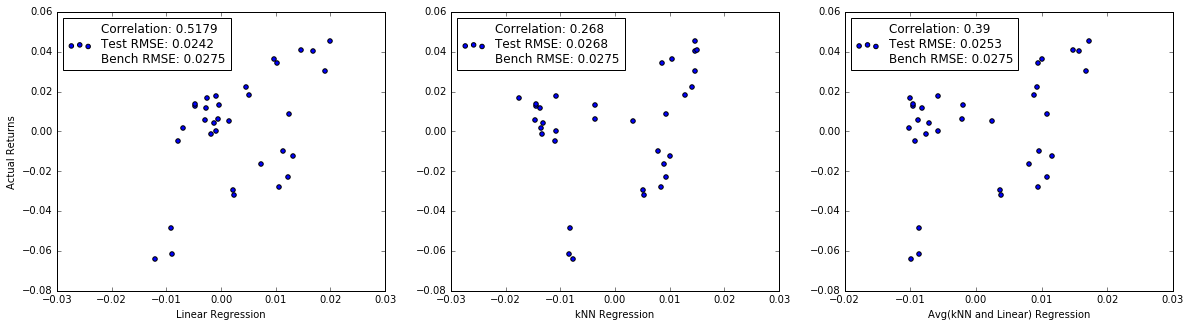

Trained from March 07, 2014 to September 10, 2014.
Tested from September 11, 2014 to October 27, 2014.


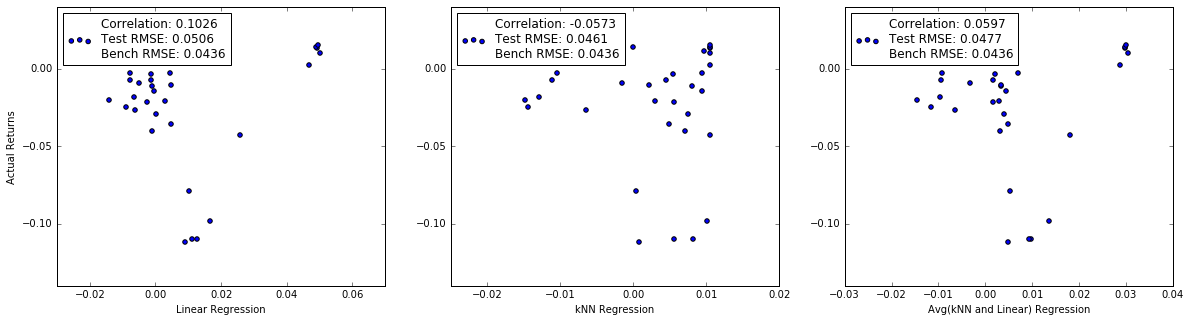

Trained from October 29, 2014 to May 06, 2015.
Tested from May 07, 2015 to June 23, 2015.


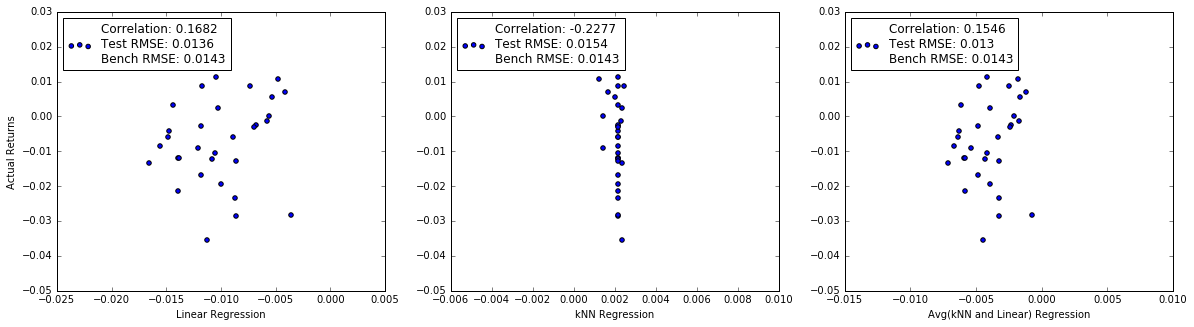

Trained from June 25, 2015 to December 29, 2015.
Tested from December 30, 2015 to February 17, 2016.


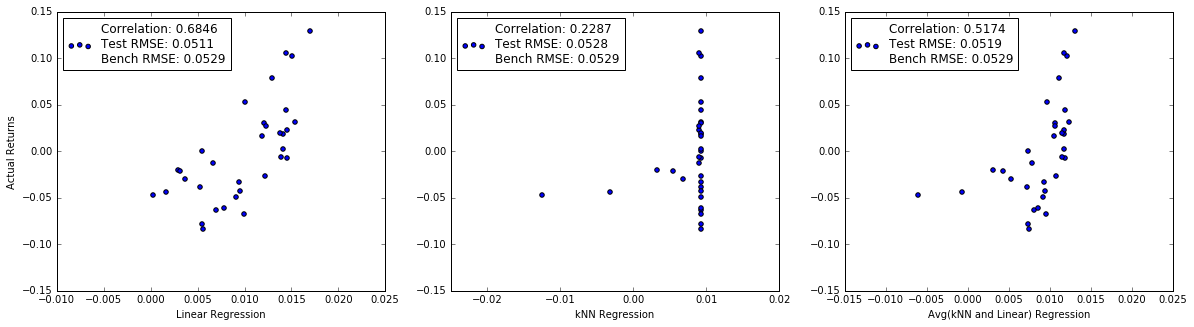

Trained from December 30, 2015 to February 17, 2016
Tested from February 23, 2016 to April 13, 2016


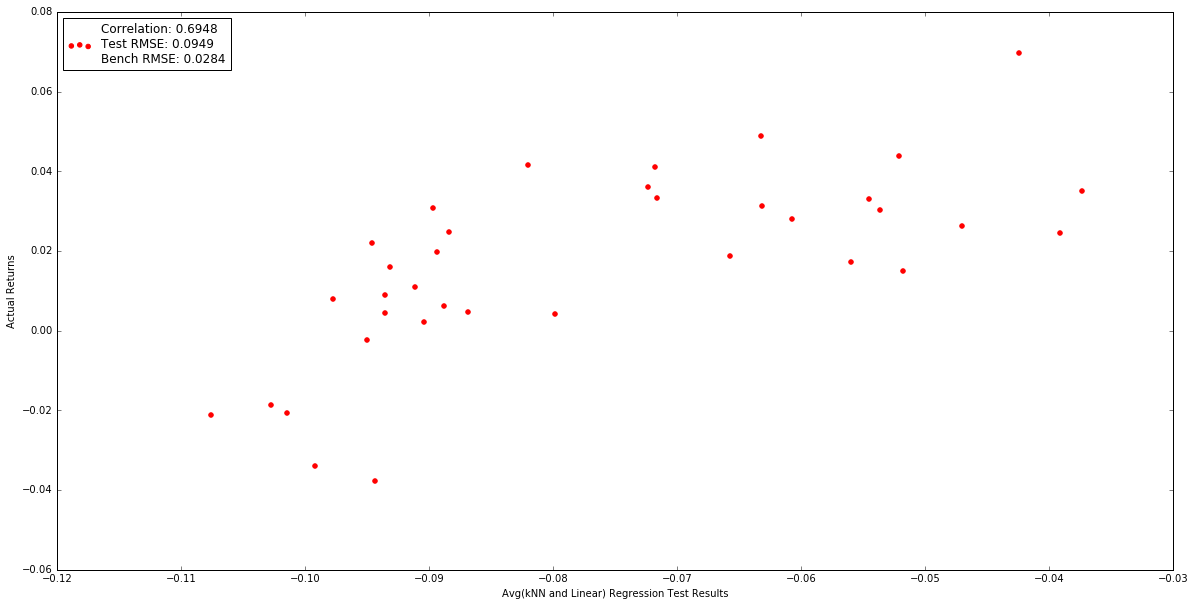

In [40]:
use_cols = [col for col in ibm_indicators
       if col in (ibm_indicators.join(ibm_future_returns).corr().ix[:,-1])[
        np.abs(ibm_indicators.join(ibm_future_returns).corr().ix[:,-1])>0.080]
      ]
dataset = ibm_indicators[use_cols].join(ibm_future_returns).dropna()
dataset = ibm_indicators.join(ibm_future_returns).dropna()
dataset = create_input("IBM", []).join(dataset["Volume_IBM"].pct_change()).join(create_output("IBM", use_prices=False)).dropna()

num_rows = dataset.shape[0]

test_rows = range(num_rows-int(0.1*num_rows), num_rows)
testX, testY = (dataset.ix[test_rows,:-1], dataset.ix[test_rows,-1])

# Remove test rows
dataset = dataset.iloc[range(0, num_rows-int(0.1*num_rows))]

dividend = 4
n_rows = dataset.shape[0]
d_rows = [(int(n_rows/dividend)*(i-1), int(n_rows/dividend)*i-1) for i in range(1,dividend+1)]
datasets = [dataset.iloc[i[0]:i[1]] for i in d_rows]

for dataset in datasets:
    train_rows = range(0, int(0.8*dataset.shape[0]))
    valid_rows = range(int(0.8*dataset.shape[0]), dataset.shape[0])
    
    print "Trained from {} to {}.".format(dataset.iloc[train_rows].index[0].strftime("%B %d, %Y"),
                                         dataset.iloc[train_rows].index[-1].strftime("%B %d, %Y"))
    print "Tested from {} to {}.".format(dataset.iloc[valid_rows].index[0].strftime("%B %d, %Y"),
                                         dataset.iloc[valid_rows].index[-1].strftime("%B %d, %Y"))

    trainX, trainY = (dataset.ix[train_rows,:-1].values, dataset.ix[train_rows,-1].values)
    validX, validY = (dataset.ix[valid_rows,:-1].values, dataset.ix[valid_rows,-1].values)

    learner = lrl()
    learner2 = knn(k=25)

    learner.addEvidence(trainX, trainY)
    learner2.addEvidence(trainX, trainY)

    resultslrl = learner.query(validX)
    resultsknn = learner2.query(validX)

    knn_preds = pd.DataFrame(resultsknn, columns=["kNN_Pred"], index=dataset.index[valid_rows])
    lrl_preds = pd.DataFrame(resultslrl, columns=["LinReg_Pred"], index=dataset.index[valid_rows])

    resultsavg = np.add(resultslrl , resultsknn)/2

    f, (plot1, plot2, plot3) = plt.subplots(1,3, figsize=(20,5) )
    plot1.scatter(x = resultslrl, y = validY, 
                  label="Correlation: {}\nTest RMSE: {}\nBench RMSE: {}".format(round(np.corrcoef(resultslrl, validY)[0,1],4),
                                                                                round(rmse(resultslrl, validY),4),
                                                                                round(rmse(np.zeros(validY.shape), validY),4)))
    plot1.legend(loc="upper left")
    plot1.set_xlabel("Linear Regression")
    plot1.set_ylabel("Actual Returns")
    plot2.scatter(x = resultsknn, y = validY, 
                  label="Correlation: {}\nTest RMSE: {}\nBench RMSE: {}".format(round(np.corrcoef(resultsknn, validY)[0,1],4),
                                                                                round(rmse(resultsknn, validY),4),
                                                                                round(rmse(np.zeros(validY.shape), validY),4)))
    plot2.legend(loc="upper left")
    plot2.set_xlabel( "kNN Regression" )
    plot3.scatter(x = resultsavg, y = validY, 
                  label="Correlation: {}\nTest RMSE: {}\nBench RMSE: {}".format(round(np.corrcoef(resultsavg, validY)[0,1],4),
                                                                                round(rmse(resultsavg, validY),4),
                                                                                round(rmse(np.zeros(validY.shape), validY),4)))
    plot3.legend(loc="upper left")
    plot3.set_xlabel( "Avg(kNN and Linear) Regression" )
    plt.show()


testX, testY = testX.iloc[:int(0.5*testX.shape[0])], testY.iloc[:int(0.5*testX.shape[0])]

print "Trained from {} to {}".format(dataset.iloc[valid_rows].index[0].strftime("%B %d, %Y"),
                                     dataset.iloc[valid_rows].index[-1].strftime("%B %d, %Y"))
print "Tested from {} to {}".format(testX.index[0].strftime("%B %d, %Y"),
                                    testX.index[-1].strftime("%B %d, %Y"))

learner = lrl()
learner.addEvidence(validX, validY)
resultslrl = learner.query(testX.values)
learner = knn()
learner.addEvidence(validX, validY)
resultsknn = learner.query(testX.values)
resultsavg = np.add(resultslrl , resultsknn)/2
plt.figure(figsize=(20,10))
plt.scatter(resultsavg, 
            testY, 
            color="r",
            label="Correlation: {}\nTest RMSE: {}\nBench RMSE: {}".format(round(np.corrcoef(resultsavg, testY)[0,1],4),
                                                                                round(rmse(resultsavg, testY),4),
                                                                                round(rmse(np.zeros(testY.shape), testY),4)))
plt.legend(loc="upper left")
plt.xlabel( "Avg(kNN and Linear) Regression Test Results" )
plt.ylabel("Actual Returns")
plt.show()

#### Predicting Future Returns

The code below shows the results of the end product at predicting returns five days into the future. The model that is used to predict returns is a simple linear regression model using information provided in the 

In [39]:
# Reports 10 symbols with the lowest test prediction error (RMSE)
print predict_spy_future(horizon=5, learner = lrl)

           Return_Date Symbol  Return(%)  Test_Error(RMSE)  Benchmark_0(RMSE)  \
Date                                                                            
2016-06-13  2016-06-20     TE   0.007342          0.004413           0.002900   
2016-06-13  2016-06-20    GAS   0.006536          0.005203           0.004787   
2016-06-13  2016-06-20    ARG  -0.015783          0.013315           0.001938   
2016-06-13  2016-06-20   WLTW   0.007141          0.013501           0.012174   
2016-06-13  2016-06-20    MMM  -0.004708          0.014129           0.012345   
2016-06-13  2016-06-20    LMT   0.002565          0.014635           0.015567   
2016-06-13  2016-06-20    ADP  -0.003031          0.014719           0.015226   
2016-06-13  2016-06-20    DGX  -0.001390          0.014832           0.017351   
2016-06-13  2016-06-20    CCI  -0.005475          0.015229           0.016291   
2016-06-13  2016-06-20    BDX   0.005836          0.015460           0.017553   

            Test_Correlatio

Averages
Unnamed: 0           251.000000
Return(%)             -0.007286
Test_Error(RMSE)       0.047697
Benchmark_0(RMSE)      0.035391
Test_Correlation       0.076080
dtype: float64

Average difference
0.0123063782806

Medians
Unnamed: 0           251.000000
Return(%)             -0.008018
Test_Error(RMSE)       0.041523
Benchmark_0(RMSE)      0.030210
Test_Correlation       0.078509
dtype: float64

Standard Deviations
Unnamed: 0           144.770508
Return(%)              0.036038
Test_Error(RMSE)       0.026909
Benchmark_0(RMSE)      0.021317
Test_Correlation       0.189483
dtype: float64


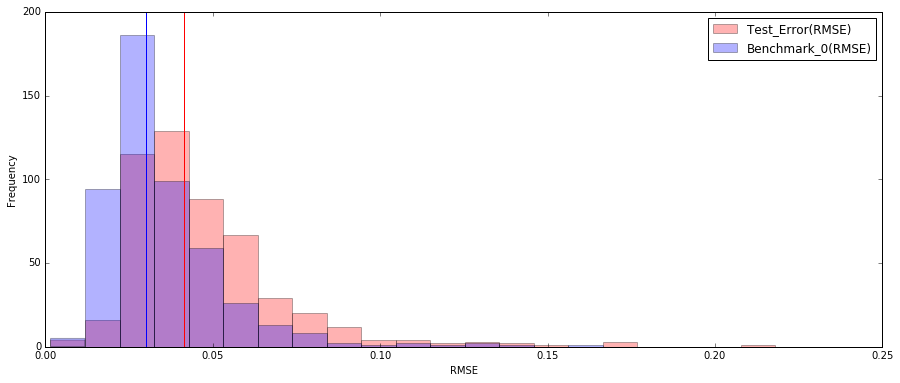

In [38]:
# Display performance statistics as they relate to the benchmark for all S&P 500 companies in spy_list.csv
predicted_returns_results = pd.read_csv("return_results.csv", index_col="Date")
print "Averages"
print predicted_returns_results.mean(axis=0)
print
print "Average difference"
print np.mean(predicted_returns_results[["Test_Error(RMSE)"]].values - predicted_returns_results[["Benchmark_0(RMSE)"]].values)
print
print "Medians"
print predicted_returns_results.median(axis=0)
print
print "Standard Deviations"
print predicted_returns_results.std(axis=0)

# Plot histogram to show performance against benchmark.
predicted_returns_results[["Test_Error(RMSE)","Benchmark_0(RMSE)"]].plot.hist(color=["r","b"],
                                                                              bins=30,
                                                                              alpha=0.3,
                                                                              figsize=(15,6))
plt.axvline(predicted_returns_results.median(axis=0)[["Test_Error(RMSE)"]].values, color="r")
plt.axvline(predicted_returns_results.median(axis=0)[["Benchmark_0(RMSE)"]].values, color="b")
plt.xlabel("RMSE")
plt.xlim((0,.25))

plt.show()

#### Predicting Future Prices

In [6]:
# Reports 10 symbols with the lowest test prediction error (MAPE)
print predict_spy_future(horizon=5, use_prices=True)

           Future_Date Symbol  Future_Price($)  Test_Error(MAPE)  \
Date                                                               
2016-06-13  2016-06-20   CPGX        24.961035          0.002709   
2016-06-13  2016-06-20     TE        26.701050          0.013141   
2016-06-13  2016-06-20    GAS        62.084152          0.015218   
2016-06-13  2016-06-20    DPS        87.823969          0.015491   
2016-06-13  2016-06-20     GD       138.415023          0.015997   
2016-06-13  2016-06-20    DVA        75.895052          0.016229   
2016-06-13  2016-06-20    CLX       123.095754          0.016567   
2016-06-13  2016-06-20     MA        94.098313          0.016723   
2016-06-13  2016-06-20    VAR        84.339223          0.017198   
2016-06-13  2016-06-20    COL        86.497707          0.017212   

            Benchmark_Last_Price(MAPE)  Test_Correlation  
Date                                                      
2016-06-13                    0.001128          0.339218  
2016-0

Averages
Unnamed: 0                    251.000000
Future_Price($)                77.696195
Test_Error(MAPE)                0.043526
Benchmark_Last_Price(MAPE)      0.026864
Test_Correlation                0.637774
dtype: float64

Average difference
0.0166619488634

Medians
Unnamed: 0                    251.000000
Future_Price($)                58.160176
Test_Error(MAPE)                0.036189
Benchmark_Last_Price(MAPE)      0.023055
Test_Correlation                0.684775
dtype: float64

Standard Deviations
Unnamed: 0                    144.770508
Future_Price($)                90.206650
Test_Error(MAPE)                0.039104
Benchmark_Last_Price(MAPE)      0.014771
Test_Correlation                0.240602
dtype: float64


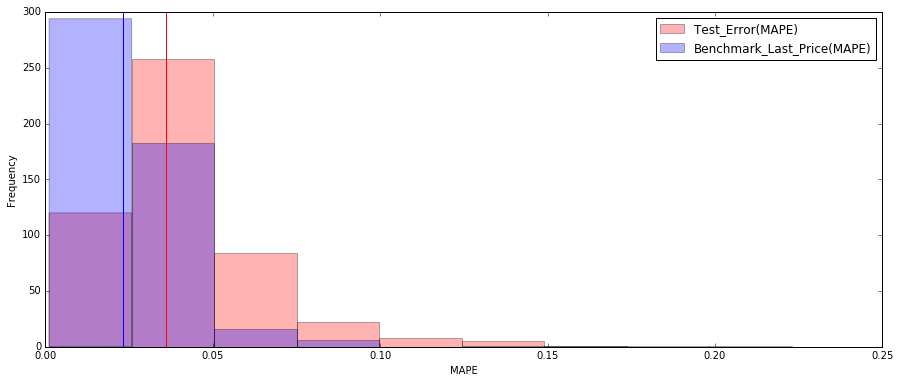

In [7]:
predicted_prices_results = pd.read_csv("price_results.csv", index_col="Date")
print "Averages"
print predicted_prices_results.mean(axis=0)
print
print "Average difference"
print np.mean(predicted_prices_results[["Test_Error(MAPE)"]].values - predicted_prices_results[["Benchmark_Last_Price(MAPE)"]].values)
print
print "Medians"
print predicted_prices_results.median(axis=0)
print
print "Standard Deviations"
print predicted_prices_results.std(axis=0)

# Plot histogram to show performance against benchmark.
predicted_prices_results[["Test_Error(MAPE)","Benchmark_Last_Price(MAPE)"]].plot.hist(color=["r","b"], 
                                                                                      bins=30, 
                                                                                      alpha=0.3,
                                                                                      figsize=(15,6))
plt.axvline(predicted_prices_results.median(axis=0)[["Test_Error(MAPE)"]].values, color="r")
plt.axvline(predicted_prices_results.median(axis=0)[["Benchmark_Last_Price(MAPE)"]].values, color="b")
plt.xlabel("MAPE")
plt.xlim((0,.25))
plt.show()

# <u>Results</u>

### Model Evaluation and Validation

#### Ensemble Models

The below predictions use an ensemble of regression models. Specifically, there are two types of regression models, k-Nearest Neighbors and Linear Regression.

Averages
Unnamed: 0           251.000000
Return(%)             -0.008036
Test_Error(RMSE)       0.039485
Benchmark_0(RMSE)      0.035391
Test_Correlation       0.154176
dtype: float64

Average difference
0.00409408201161

Medians
Unnamed: 0           251.000000
Return(%)             -0.008307
Test_Error(RMSE)       0.033713
Benchmark_0(RMSE)      0.030210
Test_Correlation       0.163974
dtype: float64

Standard Deviations
Unnamed: 0           144.770508
Return(%)              0.026117
Test_Error(RMSE)       0.023233
Benchmark_0(RMSE)      0.021317
Test_Correlation       0.203750
dtype: float64


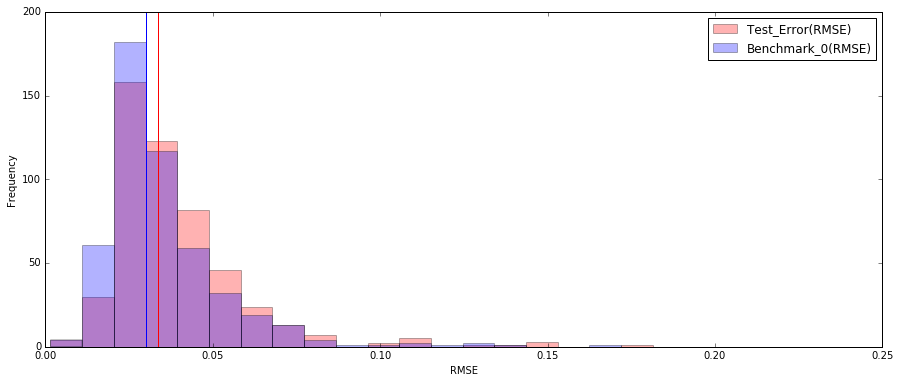

In [20]:
predict_spy_future(horizon=5, use_prices=False)
predicted_returns_results = pd.read_csv("return_results.csv", index_col="Date")
print "Averages"
print predicted_returns_results.mean(axis=0)
print
print "Average difference"
print np.mean(predicted_returns_results[["Test_Error(RMSE)"]].values - predicted_returns_results[["Benchmark_0(RMSE)"]].values)
print
print "Medians"
print predicted_returns_results.median(axis=0)
print
print "Standard Deviations"
print predicted_returns_results.std(axis=0)
predicted_returns_results[["Test_Error(RMSE)","Benchmark_0(RMSE)"]].plot.hist(color=["r","b"],bins=30,alpha=0.3,figsize=(15,6))
plt.axvline(predicted_returns_results.median(axis=0)[["Test_Error(RMSE)"]].values, color="r")
plt.axvline(predicted_returns_results.median(axis=0)[["Benchmark_0(RMSE)"]].values, color="b")
plt.xlabel("RMSE")
plt.xlim((0,.25))
plt.show()

### Justification

The results, as shown below, are comparable to the benchmark over a number of weeks. Unfortunately, when the test error beats the benchmark, the overall error is too substantial to consider as a feasible predictor of returns.

In [ ]:
bench_list, error_list = [], []
bench_std_list, error_std_list = [], []
weeks = range(1,16)
for week in weeks:
    predict_spy_future(horizon=5*week)
    test = pd.read_csv("return_results.csv", index_col="Date")
    error_list.append(test.mean(axis=0)[["Test_Error(RMSE)"]])
    bench_list.append(test.mean(axis=0)[["Benchmark_0(RMSE)"]])
    error_std_list.append(test.std(axis=0)[["Test_Error(RMSE)"]])
    bench_std_list.append(test.std(axis=0)[["Benchmark_0(RMSE)"]])

In [ ]:
error_upper_band = [mn + 3*std for mn, std in zip(error_list, error_std_list)]
bench_upper_band = [mn + 3*std for mn, std in zip(bench_list, bench_std_list)]

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
#
test_error_plot, = plt.plot(weeks, error_list, 'r', lw=3)
test_error_upper_plot, = plt.plot(weeks, error_upper_band, 'r--')
bench_error_plot, = plt.plot(weeks, bench_list, 'b', lw=3)
bench_error_upper_plot, = plt.plot(weeks, bench_upper_band, 'b--')
plt.legend([test_error_plot, test_error_upper_plot, bench_error_plot, bench_error_upper_plot], 
           ["Average Test Error", "Avg. Test Error + 3 Sigma", "Average Benchmark Error", "Avg. Bench Error + 3 Sigma"], 
           loc="upper left")
plt.xlabel("Weeks")
plt.ylabel("Estimate Error (RMSE)")

plt.show()

# <u>Conclusion</u>

### Free Form Visualization

### Reflection

### Improvement

There are a myriad of improvements that can be made to this product. There are hundreds, if not thousands, of technical indicators used in inter- and intraday trading. There is continuous analysis and debate over which indicators are most effective, just as there is the same analysis and debate over which models are most effective in this realm.

The training and testing can be updated to a rolling method. In essence, the model will be trained on a distinct period of time, then tested on a short period after the training. For example, train from August to December, test for the month of January. Ideally, this method will be more dynamic and, by that virtue, more robust to changing market conditions. Further validation would be necessary to determine the optimal training and testing periods for any model.